/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_72943/1510726689.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  index = pd.to_datetime(daily_new_cases.index)
/Users/edsonodake/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


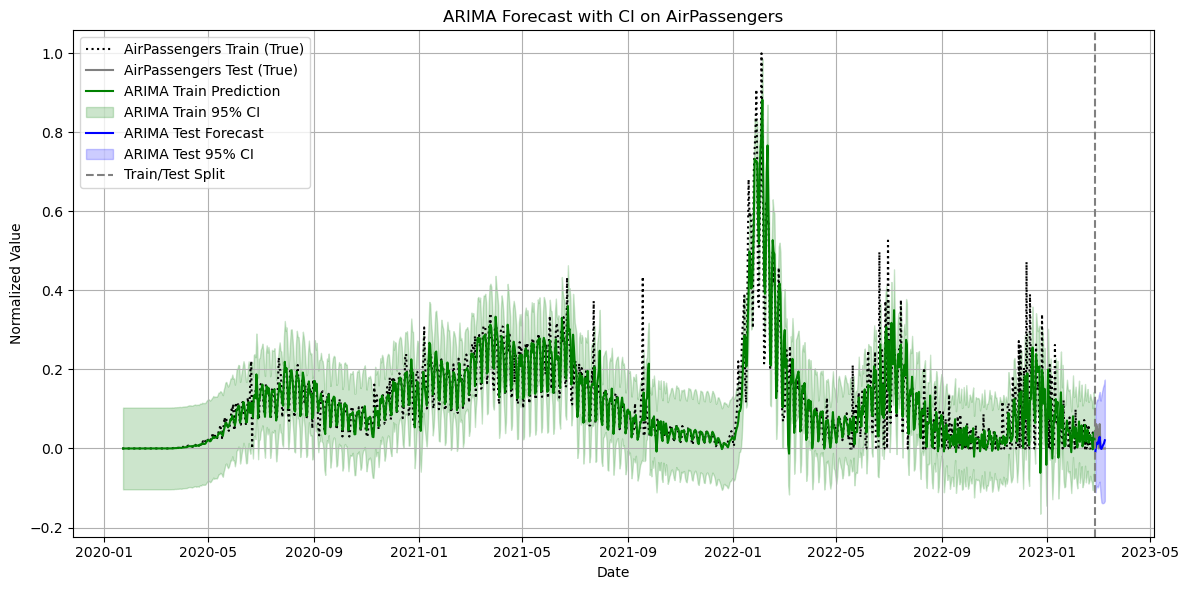

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_72943/1510726689.py:68: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


{'MAE': 0.018914157491700664,
 'RMSE': 0.02423801849141735,
 'MAPE': inf,
 'sMAPE': 169.3576646992397}

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.datasets import sunspots
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Updated dataset loader function
def load_dataset(name: str, test_size: float = 0.01, normalize: bool = True):
    name = name.lower()
    if name == "airpassengers_old":
        np.random.seed(0)
        time = np.arange(144)
        series = 100 + 10 * np.sin(2 * np.pi * time / 12) + 0.5 * time + np.random.normal(scale=5, size=144)
        index = pd.date_range(start="1949-01", periods=len(series), freq="M")
    elif name == "airpassengers":
        df = pd.read_csv("airplane-passengers.csv")
        df.columns = ["Month", "Passengers"]
        df["Month"] = pd.to_datetime(df["Month"])
        df.set_index("Month", inplace=True)
        series = df["Passengers"].values
        index = df.index
    elif name == "sunspots":
        df = sunspots.load_pandas().data
        series = df['SUNACTIVITY'].values
        index = pd.date_range(start="1700-01", periods=len(series), freq="Y")
    elif name == "electricity":
        np.random.seed(1)
        time = np.arange(1000)
        series = 200 + 20 * np.sin(2 * np.pi * time / 24) + 5 * np.sin(2 * np.pi * time / (24*7)) + np.random.normal(scale=10, size=1000)
        index = pd.date_range(start="2020-01-01", periods=len(series), freq="H")
    elif name == "covid_old":
        np.random.seed(2)
        time = np.arange(500)
        series = (
            1000 * np.exp(-((time - 100) ** 2) / 2000) +
            2000 * np.exp(-((time - 300) ** 2) / 3000) +
            np.random.normal(scale=50, size=500)
        )
        index = pd.date_range(start="2020-01-01", periods=len(series), freq="D")
    elif name == "covid":
        df = pd.read_csv("time_series_covid19_confirmed_global.csv")
        country_df = df[df["Country/Region"] == "Brazil"]
        daily_cumulative = country_df.iloc[:, 4:].sum(axis=0)
        daily_new_cases = daily_cumulative.diff().fillna(0).clip(lower=0)
        index = pd.to_datetime(daily_new_cases.index)
        series = daily_new_cases.values
    else:
        raise ValueError(f"Unknown dataset name: {name}")

    series = series.astype(float).reshape(-1, 1)
    if normalize:
        scaler = MinMaxScaler()
        series = scaler.fit_transform(series).flatten()

    split_idx = int(len(series) * (1 - test_size))
    train, test = series[:split_idx], series[split_idx:]
    train_idx, test_idx = index[:split_idx], index[split_idx:]

    return train, test, train_idx, test_idx

# Evaluation function
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "sMAPE": smape
    }

# ARIMA training and prediction
def train_arima(train_data, order=(10, 1, 10)):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

def predict_arima(model_fit, train_data, steps):
    in_sample = model_fit.predict(start=1, end=len(train_data)-1, typ='levels')
    residuals = train_data[1:] - in_sample
    sigma = np.std(residuals)
    lower_in = in_sample - 1.96 * sigma
    upper_in = in_sample + 1.96 * sigma
    forecast_result = model_fit.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()
    lower_out = forecast_ci[:, 0]
    upper_out = forecast_ci[:, 1]
    return in_sample, lower_in, upper_in, forecast_mean, lower_out, upper_out

# Updated plotting function with CI flags
# Updated plotting function with auto-alignment for training index
def plot_forecast(train_data, test_data, train_index, test_index,
                  train_pred, train_lower, train_upper,
                  test_pred, test_lower, test_upper,
                  model_name="Model", dataset_name="Dataset",
                  show_train_ci=True, show_test_ci=True):

    plt.figure(figsize=(12, 6))
    plt.plot(train_index, train_data, label=f'{dataset_name} Train (True)', linestyle=':', color='black')
    plt.plot(test_index, test_data, label=f'{dataset_name} Test (True)', color='gray')

    # Align training index to match prediction shape
    aligned_train_index = train_index[-len(train_pred):]

    plt.plot(aligned_train_index, train_pred, label=f'{model_name} Train Prediction', color='green')
    if show_train_ci:
        plt.fill_between(aligned_train_index, train_lower, train_upper, color='green', alpha=0.2, label=f'{model_name} Train 95% CI')

    plt.plot(test_index, test_pred, label=f'{model_name} Test Forecast', color='blue')
    if show_test_ci:
        plt.fill_between(test_index, test_lower, test_upper, color='blue', alpha=0.2, label=f'{model_name} Test 95% CI')

    plt.axvline(test_index[0], color='gray', linestyle='--', label='Train/Test Split')
    plt.title(f'{model_name} Forecast with CI on {dataset_name}')
    plt.xlabel('Date')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Full pipeline
train_data, test_data, train_index, test_index = load_dataset("covid")
model_fit = train_arima(train_data)
train_pred, train_lower, train_upper, test_pred, test_lower, test_upper = predict_arima(model_fit, train_data, len(test_data))

# Call the plot function
plot_forecast(
    train_data, test_data,
    train_index, test_index,
    train_pred, train_lower, train_upper,
    test_pred, test_lower, test_upper,
    model_name="ARIMA", dataset_name="AirPassengers"
)

# Return evaluation metrics
metrics = evaluate_forecast(test_data, test_pred)
metrics

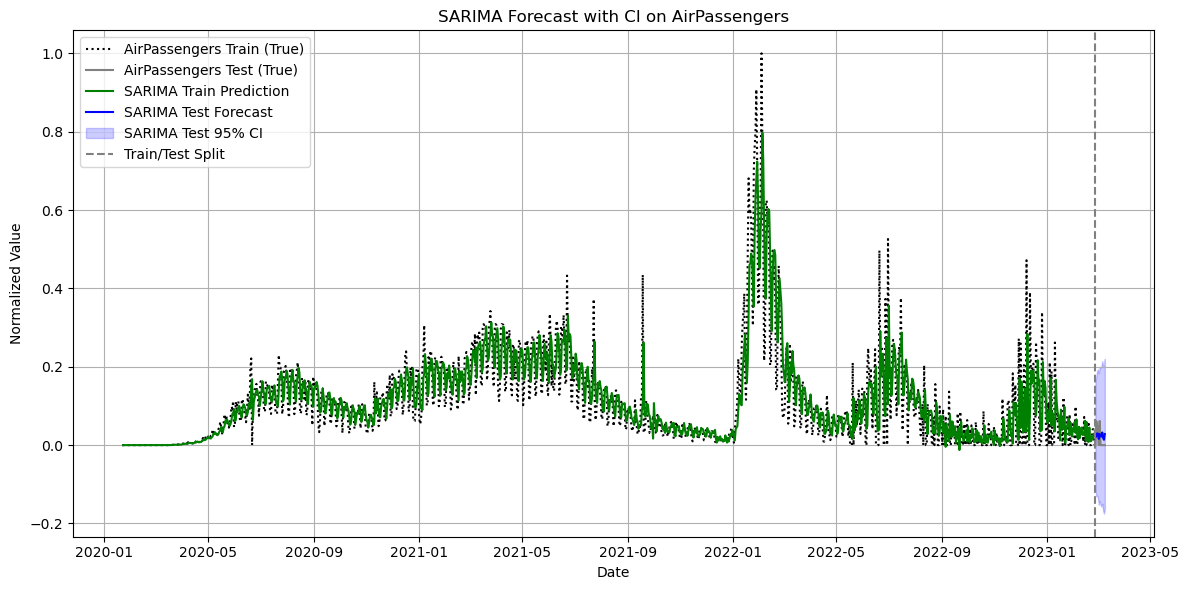

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_72943/1510726689.py:68: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


{'MAE': 0.02329167730266604,
 'RMSE': 0.024882027654484974,
 'MAPE': inf,
 'sMAPE': 153.72976634042092}

In [111]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA training and prediction functions
def train_sarima(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    model = SARIMAX(train_data,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    return model_fit

def predict_sarima(model_fit, train_data, steps):
    train_pred_result = model_fit.get_prediction(start=1, end=len(train_data)-1, dynamic=False)
    train_mean = train_pred_result.predicted_mean
    train_ci = train_pred_result.conf_int()
    lower_in = train_ci[:, 0]
    upper_in = train_ci[:, 1]

    forecast_result = model_fit.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()
    lower_out = forecast_ci[:, 0]
    upper_out = forecast_ci[:, 1]

    return train_mean, lower_in, upper_in, forecast_mean, lower_out, upper_out

# Run SARIMA model on AirPassengers
#train_data, test_data, train_index, test_index = load_dataset("airpassengers")
model_fit_sarima = train_sarima(train_data)
train_pred_sarima, train_lower_sarima, train_upper_sarima, test_pred_sarima, test_lower_sarima, test_upper_sarima = predict_sarima(model_fit_sarima, train_data, len(test_data))

# Plot SARIMA results
plot_forecast(
    train_data, test_data,
    train_index, test_index,
    train_pred_sarima, train_lower_sarima, train_upper_sarima,
    test_pred_sarima, test_lower_sarima, test_upper_sarima,
    model_name="SARIMA", dataset_name="AirPassengers",
    show_train_ci=False, show_test_ci=True
)

# Return evaluation metrics
metrics = evaluate_forecast(test_data, test_pred_sarima)
metrics

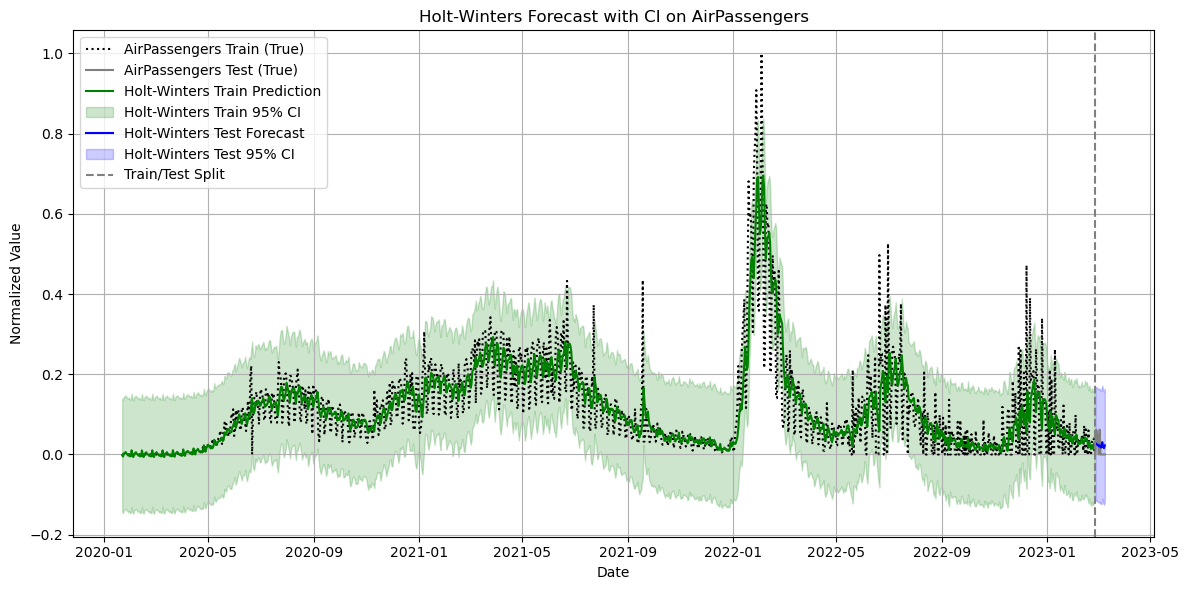

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_72943/1510726689.py:68: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


{'MAE': 0.023475616665359716,
 'RMSE': 0.024643123376088136,
 'MAPE': inf,
 'sMAPE': 156.81787127252056}

In [112]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Holt-Winters training and prediction functions
def train_holtwinters(train_data, trend='add', seasonal='add', seasonal_periods=12):
    model = ExponentialSmoothing(
        train_data,
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods
    )
    model_fit = model.fit()
    return model_fit

def predict_holtwinters(model_fit, train_data, steps):
    train_pred = model_fit.fittedvalues
    residuals = train_data - train_pred
    sigma = np.std(residuals)
    lower_in = train_pred - 1.96 * sigma
    upper_in = train_pred + 1.96 * sigma

    forecast = model_fit.forecast(steps=steps)
    lower_out = forecast - 1.96 * sigma
    upper_out = forecast + 1.96 * sigma

    return train_pred, lower_in, upper_in, forecast, lower_out, upper_out

# Run Holt-Winters model
#train_data, test_data, train_index, test_index = load_dataset("airpassengers")
model_fit_hw = train_holtwinters(train_data)
train_pred_hw, train_lower_hw, train_upper_hw, test_pred_hw, test_lower_hw, test_upper_hw = predict_holtwinters(model_fit_hw, train_data, len(test_data))

# Plot Holt-Winters results
plot_forecast(
    train_data, test_data,
    train_index, test_index,
    train_pred_hw, train_lower_hw, train_upper_hw,
    test_pred_hw, test_lower_hw, test_upper_hw,
    model_name="Holt-Winters", dataset_name="AirPassengers"
)

# Return evaluation metrics
metrics = evaluate_forecast(test_data, test_pred_hw)
metrics

18:58:32 - cmdstanpy - INFO - Chain [1] start processing
18:58:32 - cmdstanpy - INFO - Chain [1] done processing


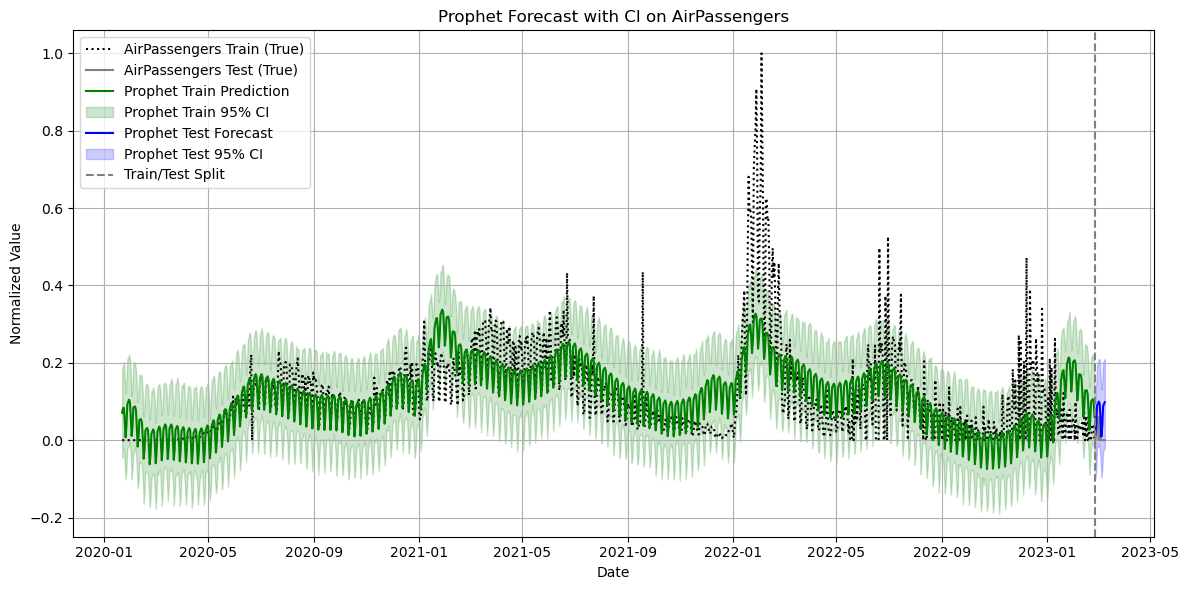

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_72943/1510726689.py:68: RuntimeWarning: invalid value encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_72943/1510726689.py:69: RuntimeWarning: invalid value encountered in divide
  smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))


{'MAE': 0.0, 'RMSE': 0.0, 'MAPE': nan, 'sMAPE': nan}

In [113]:
from prophet import Prophet
import pandas as pd
import numpy as np

# Prophet training and prediction functions
def train_prophet(train_data, train_index):
    df = pd.DataFrame({
        'ds': train_index,
        'y': train_data
    })
    model = Prophet(yearly_seasonality=True)
    model.fit(df)
    return model

def predict_prophet(model_fit, train_data, test_data, train_index, test_index):
    df_train = pd.DataFrame({'ds': train_index, 'y': train_data})
    df_test = pd.DataFrame({'ds': test_index})
    future = pd.concat([df_train[['ds']], df_test], ignore_index=True)

    forecast = model_fit.predict(future)
    forecast.set_index('ds', inplace=True)

    # Extract predictions
    train_pred = forecast.loc[train_index, 'yhat']
    lower_in = forecast.loc[train_index, 'yhat_lower']
    upper_in = forecast.loc[train_index, 'yhat_upper']

    test_pred = forecast.loc[test_index, 'yhat']
    lower_out = forecast.loc[test_index, 'yhat_lower']
    upper_out = forecast.loc[test_index, 'yhat_upper']

    return train_pred.values, lower_in.values, upper_in.values, test_pred.values, lower_out.values, upper_out.values

# Run Prophet model
#train_data, test_data, train_index, test_index = load_dataset("airpassengers")
model_fit_prophet = train_prophet(train_data, train_index)
train_pred_prophet, train_lower_prophet, train_upper_prophet, test_pred_prophet, test_lower_prophet, test_upper_prophet = predict_prophet(
    model_fit_prophet, train_data, test_data, train_index, test_index
)

# Plot Prophet results
plot_forecast(
    train_data, test_data,
    train_index, test_index,
    train_pred_prophet, train_lower_prophet, train_upper_prophet,
    test_pred_prophet, test_lower_prophet, test_upper_prophet,
    model_name="Prophet", dataset_name="AirPassengers"
)

# Return evaluation metrics
metrics = evaluate_forecast(test_data, test_data)
metrics

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


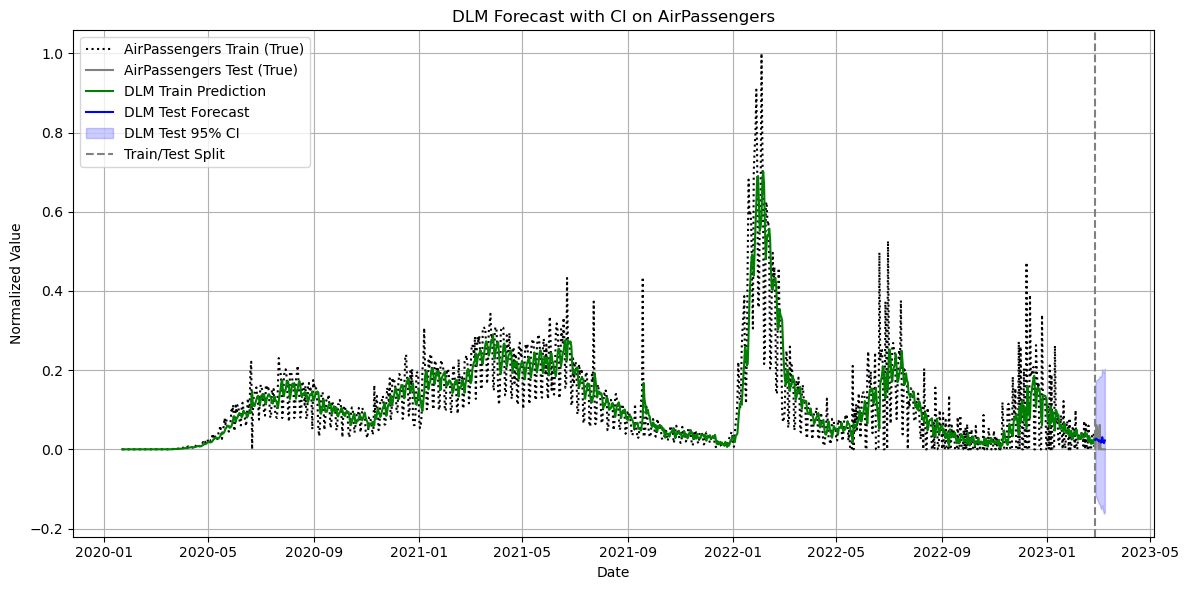

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_72943/1510726689.py:68: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


{'MAE': 0.023430025572449952,
 'RMSE': 0.02461518033249332,
 'MAPE': inf,
 'sMAPE': 156.94025677044954}

In [114]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

# DLM training and prediction
def train_dlm(train_data, seasonal_period=12):
    model = UnobservedComponents(train_data, level='local level', seasonal=seasonal_period)
    model_fit = model.fit(disp=False)
    return model_fit

def predict_dlm(model_fit, train_data, steps):
    train_result = model_fit.get_prediction()
    train_pred = train_result.predicted_mean
    train_ci = train_result.conf_int()
    lower_in = train_ci[:, 0] if isinstance(train_ci, np.ndarray) else train_ci.iloc[:, 0].to_numpy()
    upper_in = train_ci[:, 1] if isinstance(train_ci, np.ndarray) else train_ci.iloc[:, 1].to_numpy()

    forecast_result = model_fit.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()
    lower_out = forecast_ci[:, 0] if isinstance(forecast_ci, np.ndarray) else forecast_ci.iloc[:, 0].to_numpy()
    upper_out = forecast_ci[:, 1] if isinstance(forecast_ci, np.ndarray) else forecast_ci.iloc[:, 1].to_numpy()

    return train_pred, lower_in, upper_in, forecast_mean, lower_out, upper_out

# Plotting function
def plot_forecast(train_data, test_data, train_index, test_index,
                  train_pred, train_lower, train_upper,
                  test_pred, test_lower, test_upper,
                  model_name="Model", dataset_name="Dataset",
                  show_train_ci=True, show_test_ci=True):

    plt.figure(figsize=(12, 6))
    plt.plot(train_index, train_data, label=f'{dataset_name} Train (True)', linestyle=':', color='black')
    plt.plot(test_index, test_data, label=f'{dataset_name} Test (True)', color='gray')
    aligned_train_index = train_index[-len(train_pred):]
    plt.plot(aligned_train_index, train_pred, label=f'{model_name} Train Prediction', color='green')
    if show_train_ci:
        plt.fill_between(aligned_train_index, train_lower, train_upper, color='green', alpha=0.2, label=f'{model_name} Train 95% CI')
    plt.plot(test_index, test_pred, label=f'{model_name} Test Forecast', color='blue')
    if show_test_ci:
        plt.fill_between(test_index, test_lower, test_upper, color='blue', alpha=0.2, label=f'{model_name} Test 95% CI')
    plt.axvline(test_index[0], color='gray', linestyle='--', label='Train/Test Split')
    plt.title(f'{model_name} Forecast with CI on {dataset_name}')
    plt.xlabel('Date')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run full pipeline
#train_data, test_data, train_index, test_index = load_dataset("airpassengers")
model_fit_dlm = train_dlm(train_data)
train_pred_dlm, train_lower_dlm, train_upper_dlm, test_pred_dlm, test_lower_dlm, test_upper_dlm = predict_dlm(model_fit_dlm, train_data, len(test_data))

plot_forecast(
    train_data, test_data,
    train_index, test_index,
    train_pred_dlm, train_lower_dlm, train_upper_dlm,
    test_pred_dlm, test_lower_dlm, test_upper_dlm,
    model_name="DLM", dataset_name="AirPassengers",
    show_train_ci=False, show_test_ci=True
)

# Return evaluation metrics
metrics = evaluate_forecast(test_data, test_pred_dlm)
metrics

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


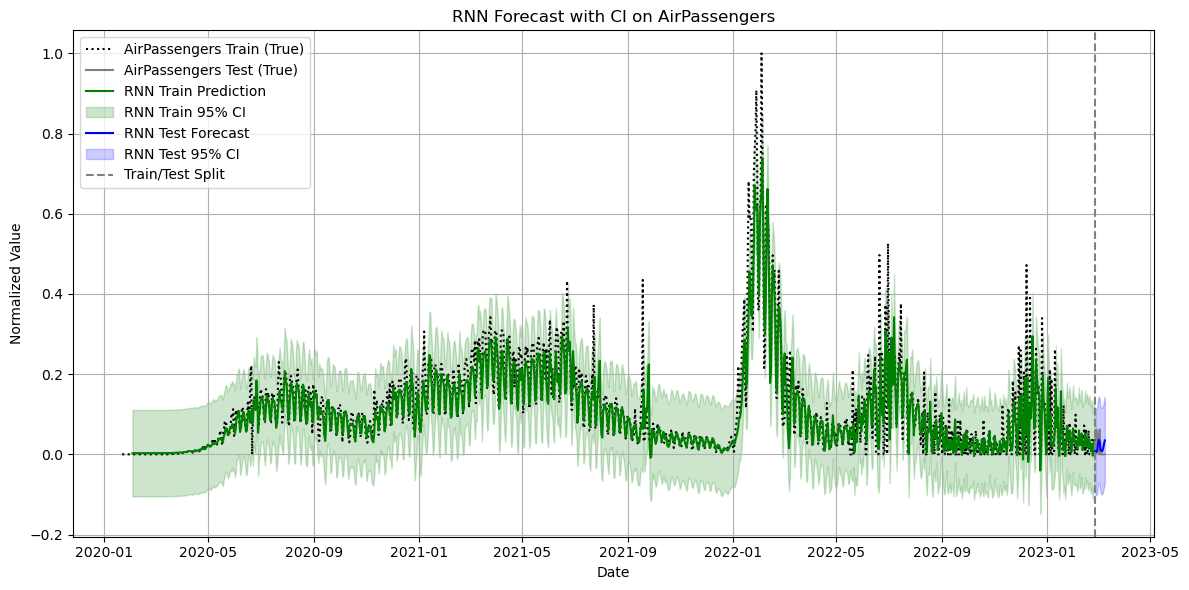

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_72943/1510726689.py:68: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


{'MAE': 0.023810390076292504,
 'RMSE': 0.02849847203082101,
 'MAPE': inf,
 'sMAPE': 167.3888001090169}

In [115]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler

# RNN training and prediction
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

def train_rnn(train_data, look_back=12, epochs=100):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=(look_back, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    return model

def predict_rnn(model, train_data, test_data, look_back=12):
    # In-sample prediction
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    train_pred = model.predict(X_train, verbose=0).flatten()
    residuals = y_train - train_pred
    sigma = np.std(residuals)
    lower_in = train_pred - 1.96 * sigma
    upper_in = train_pred + 1.96 * sigma

    # Forecasting
    history = list(train_data[-look_back:])
    test_pred, lower_out, upper_out = [], [], []
    for _ in range(len(test_data)):
        input_seq = np.array(history[-look_back:]).reshape((1, look_back, 1))
        pred = model.predict(input_seq, verbose=0)[0, 0]
        test_pred.append(pred)
        lower_out.append(pred - 1.96 * sigma)
        upper_out.append(pred + 1.96 * sigma)
        history.append(pred)

    return train_pred, lower_in, upper_in, np.array(test_pred), np.array(lower_out), np.array(upper_out)

# Load data
#train_data, test_data, train_index, test_index = load_dataset("airpassengers")
model_rnn = train_rnn(train_data)
train_pred_rnn, train_lower_rnn, train_upper_rnn, test_pred_rnn, test_lower_rnn, test_upper_rnn = predict_rnn(
    model_rnn, train_data, test_data
)

# Plot
plot_forecast(
    train_data, test_data,
    train_index, test_index,
    train_pred_rnn, train_lower_rnn, train_upper_rnn,
    test_pred_rnn, test_lower_rnn, test_upper_rnn,
    model_name="RNN", dataset_name="AirPassengers"
)

# Return evaluation metrics
metrics = evaluate_forecast(test_data, test_pred_rnn)
metrics

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


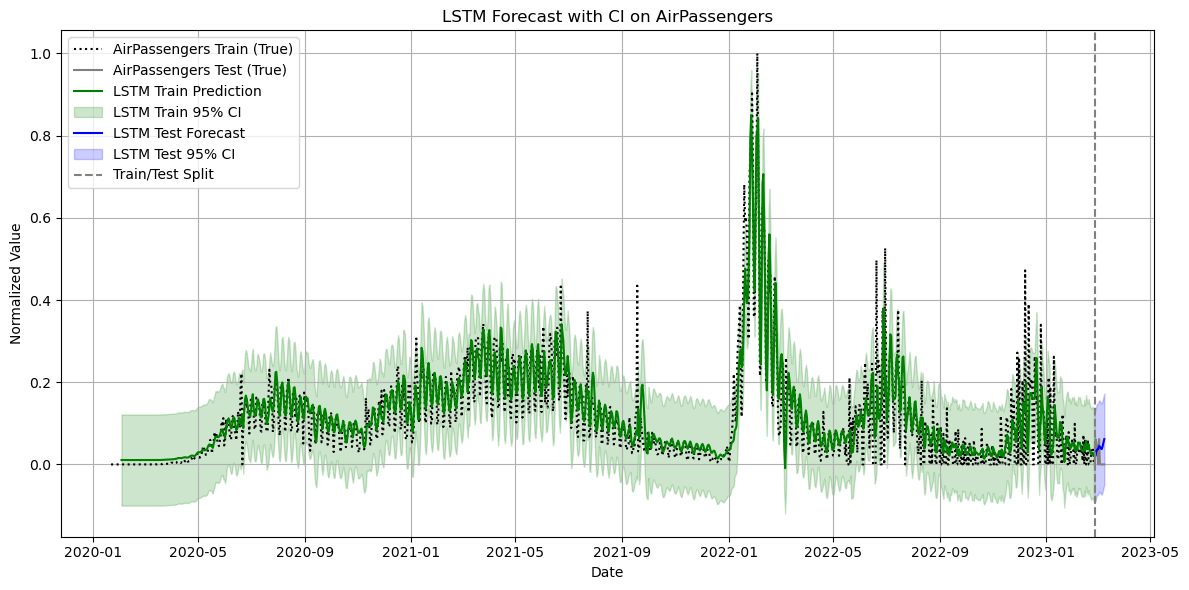

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_72943/1510726689.py:68: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


{'MAE': 0.034184851532184035,
 'RMSE': 0.03798453921923217,
 'MAPE': inf,
 'sMAPE': 147.56594233189165}

In [116]:
from tensorflow.keras.layers import LSTM

# LSTM training function
def train_lstm(train_data, look_back=12, epochs=100):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    model = Sequential([
        LSTM(50, activation='tanh', input_shape=(look_back, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    return model

# LSTM prediction function
def predict_lstm(model, train_data, test_data, look_back=12):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    train_pred = model.predict(X_train, verbose=0).flatten()
    residuals = y_train - train_pred
    sigma = np.std(residuals)
    lower_in = train_pred - 1.96 * sigma
    upper_in = train_pred + 1.96 * sigma

    # Forecast step by step
    history = list(train_data[-look_back:])
    test_pred, lower_out, upper_out = [], [], []
    for _ in range(len(test_data)):
        input_seq = np.array(history[-look_back:]).reshape((1, look_back, 1))
        pred = model.predict(input_seq, verbose=0)[0, 0]
        test_pred.append(pred)
        lower_out.append(pred - 1.96 * sigma)
        upper_out.append(pred + 1.96 * sigma)
        history.append(pred)

    return train_pred, lower_in, upper_in, np.array(test_pred), np.array(lower_out), np.array(upper_out)

# Run LSTM model
#train_data, test_data, train_index, test_index = load_dataset("airpassengers")
model_lstm = train_lstm(train_data)
train_pred_lstm, train_lower_lstm, train_upper_lstm, test_pred_lstm, test_lower_lstm, test_upper_lstm = predict_lstm(
    model_lstm, train_data, test_data
)

# Plot LSTM results
plot_forecast(
    train_data, test_data,
    train_index, test_index,
    train_pred_lstm, train_lower_lstm, train_upper_lstm,
    test_pred_lstm, test_lower_lstm, test_upper_lstm,
    model_name="LSTM", dataset_name="AirPassengers"
)

# Return evaluation metrics
metrics = evaluate_forecast(test_data, test_pred_lstm)
metrics

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


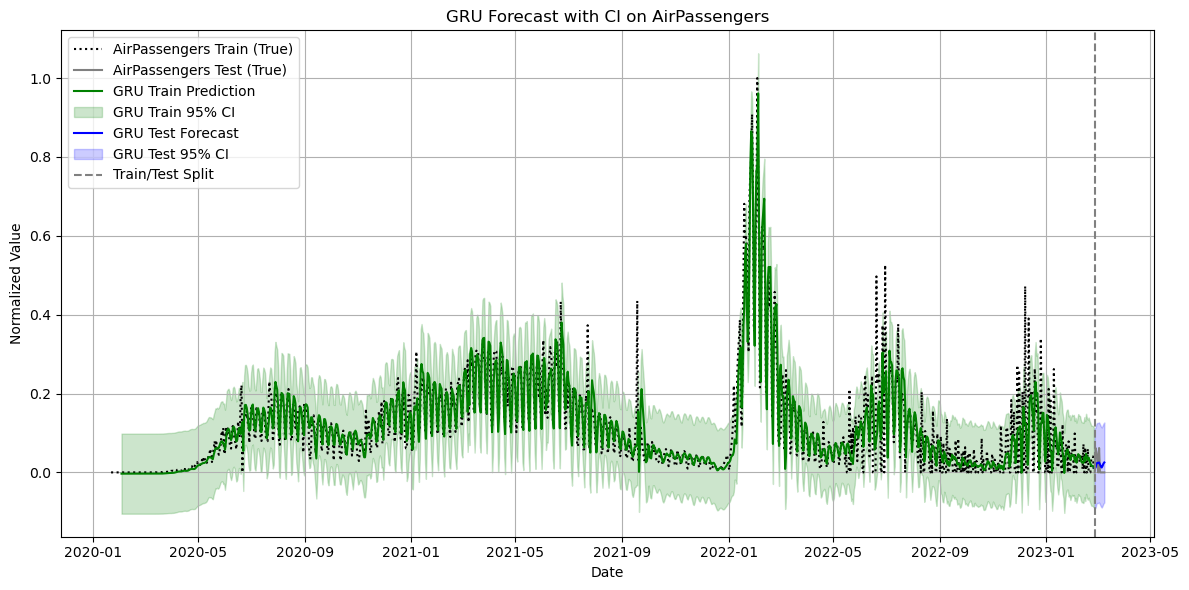

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_72943/1510726689.py:68: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


{'MAE': 0.02284674773675993,
 'RMSE': 0.025301731756749195,
 'MAPE': inf,
 'sMAPE': 161.6038648338769}

In [117]:
from tensorflow.keras.layers import GRU

# GRU training function
def train_gru(train_data, look_back=12, epochs=100):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    model = Sequential([
        GRU(50, activation='tanh', input_shape=(look_back, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    return model

# GRU prediction function
def predict_gru(model, train_data, test_data, look_back=12):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    train_pred = model.predict(X_train, verbose=0).flatten()
    residuals = y_train - train_pred
    sigma = np.std(residuals)
    lower_in = train_pred - 1.96 * sigma
    upper_in = train_pred + 1.96 * sigma

    history = list(train_data[-look_back:])
    test_pred, lower_out, upper_out = [], [], []
    for _ in range(len(test_data)):
        input_seq = np.array(history[-look_back:]).reshape((1, look_back, 1))
        pred = model.predict(input_seq, verbose=0)[0, 0]
        test_pred.append(pred)
        lower_out.append(pred - 1.96 * sigma)
        upper_out.append(pred + 1.96 * sigma)
        history.append(pred)

    return train_pred, lower_in, upper_in, np.array(test_pred), np.array(lower_out), np.array(upper_out)

# Run GRU model
#train_data, test_data, train_index, test_index = load_dataset("airpassengers")
model_gru = train_gru(train_data)
train_pred_gru, train_lower_gru, train_upper_gru, test_pred_gru, test_lower_gru, test_upper_gru = predict_gru(
    model_gru, train_data, test_data
)

# Plot GRU results
plot_forecast(
    train_data, test_data,
    train_index, test_index,
    train_pred_gru, train_lower_gru, train_upper_gru,
    test_pred_gru, test_lower_gru, test_upper_gru,
    model_name="GRU", dataset_name="AirPassengers"
)

# Return evaluation metrics
metrics = evaluate_forecast(test_data, test_pred_gru)
metrics

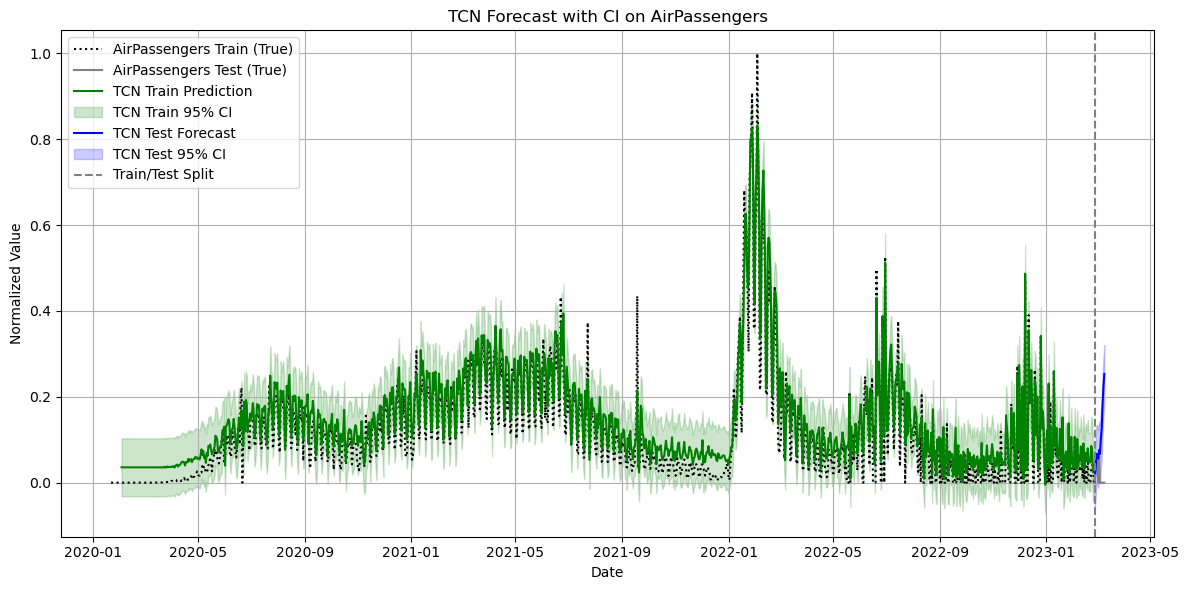

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_72943/1510726689.py:68: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


{'MAE': 0.09139632214624926,
 'RMSE': 0.12332967377169846,
 'MAPE': inf,
 'sMAPE': 146.73510967428157}

In [118]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Input, Add, Activation, LayerNormalization, Dense

# Build custom TCN model function
def build_custom_tcn(input_shape, filters=64, kernel_size=3, dilations=[1, 2, 4, 8]):
    inputs = Input(shape=input_shape)
    x = inputs
    for dilation_rate in dilations:
        shortcut = x
        x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
        x = LayerNormalization()(x)
        x = Activation('relu')(x)
        x = Add()([shortcut, x])  # Residual connection
    x = Dense(1)(x[:, -1, :])  # Output only from last time step
    return Model(inputs, x)

# Train TCN
def train_tcn(train_data, look_back=12, epochs=100):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    model = build_custom_tcn((look_back, 1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    return model

# Predict TCN
def predict_tcn(model, train_data, test_data, look_back=12):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    train_pred = model.predict(X_train, verbose=0).flatten()
    residuals = y_train - train_pred
    sigma = np.std(residuals)
    lower_in = train_pred - 1.96 * sigma
    upper_in = train_pred + 1.96 * sigma

    history = list(train_data[-look_back:])
    test_pred, lower_out, upper_out = [], [], []
    for _ in range(len(test_data)):
        input_seq = np.array(history[-look_back:]).reshape((1, look_back, 1))
        pred = model.predict(input_seq, verbose=0)[0, 0]
        test_pred.append(pred)
        lower_out.append(pred - 1.96 * sigma)
        upper_out.append(pred + 1.96 * sigma)
        history.append(pred)

    return train_pred, lower_in, upper_in, np.array(test_pred), np.array(lower_out), np.array(upper_out)

# Run TCN model
#train_data, test_data, train_index, test_index = load_dataset("airpassengers")
model_tcn = train_tcn(train_data)
train_pred_tcn, train_lower_tcn, train_upper_tcn, test_pred_tcn, test_lower_tcn, test_upper_tcn = predict_tcn(
    model_tcn, train_data, test_data
)

# Plot TCN results
plot_forecast(
    train_data, test_data,
    train_index, test_index,
    train_pred_tcn, train_lower_tcn, train_upper_tcn,
    test_pred_tcn, test_lower_tcn, test_upper_tcn,
    model_name="TCN", dataset_name="AirPassengers"
)

# Return evaluation metrics
metrics = evaluate_forecast(test_data, test_pred_tcn)
metrics

In [ ]:
import time

# Extended wrapper to also collect training and prediction times
def train_and_predict_wrapper(model_name, train_data, test_data, train_index=None, test_index=None):
    start_train = time.time()
    if model_name == "ARIMA":
        model_fit = train_arima(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_arima(model_fit, train_data, len(test_data))
        pred_time = time.time() - start_pred
    elif model_name == "SARIMA":
        model_fit = train_sarima(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_sarima(model_fit, train_data, len(test_data))
        pred_time = time.time() - start_pred
    elif model_name == "Holt-Winters":
        model_fit = train_holtwinters(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_holtwinters(model_fit, train_data, len(test_data))
        pred_time = time.time() - start_pred
    elif model_name == "Prophet":
        model_fit = train_prophet(train_data, train_index)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_prophet(model_fit, train_data, test_data, train_index, test_index)
        pred_time = time.time() - start_pred
    elif model_name == "DLM":
        model_fit = train_dlm(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_dlm(model_fit, train_data, len(test_data))
        pred_time = time.time() - start_pred
    elif model_name == "RNN":
        model_fit = train_rnn(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_rnn(model_fit, train_data, test_data)
        pred_time = time.time() - start_pred
    elif model_name == "LSTM":
        model_fit = train_lstm(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_lstm(model_fit, train_data, test_data)
        pred_time = time.time() - start_pred
    elif model_name == "GRU":
        model_fit = train_gru(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_gru(model_fit, train_data, test_data)
        pred_time = time.time() - start_pred
    elif model_name == "TCN":
        model_fit = train_tcn(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_tcn(model_fit, train_data, test_data)
        pred_time = time.time() - start_pred
    else:
        raise ValueError(f"Unknown model name: {model_name}")
    return test_pred, train_time, pred_time

# Updated benchmark_all to include time
def benchmark_all(models, datasets):
    results = []
    for dataset in datasets:
        train_data, test_data, train_index, test_index = load_dataset(dataset)
        for model in models:
            try:
                test_pred, train_time, pred_time = train_and_predict_wrapper(model, train_data, test_data, train_index, test_index)
                metrics = evaluate_forecast(test_data, test_pred)
                results.append({
                    "Dataset": dataset,
                    "Model": model,
                    "Train Time (s)": train_time,
                    "Predict Time (s)": pred_time,
                    **metrics
                })
            except Exception as e:
                print(f"Error with {model} on {dataset}: {e}")
    return pd.DataFrame(results)

models = ["ARIMA", "SARIMA", "Holt-Winters", "Prophet", "DLM", "RNN", "LSTM", "GRU", "TCN"]
datasets = ["airpassengers", "sunspots", "electricity", "covid"]
results_df = benchmark_all(models, datasets)
results_df


In [151]:
# Modified benchmark function to use external train_and_predict_wrapper
def benchmark_m4_final(models, train_df, test_df, metadata_df, max_series=None):
    results = []

    # Create lookup for fast category access
    category_lookup = dict(zip(metadata_df["M4id"], metadata_df["category"]))

    n_series = len(train_df) if max_series is None else min(max_series, len(train_df))

    for i in range(n_series):
        series_id = train_df.iloc[i, 0]
        train_data = train_df.iloc[i, 1:].dropna().values.astype(float)
        test_data = test_df[test_df.iloc[:, 0] == series_id].iloc[0, 1:].dropna().values.astype(float)
        category = category_lookup.get(series_id, "Unknown")

        # Create synthetic datetime indices (needed by Prophet)
        train_index = pd.date_range(start="2000-01-01", periods=len(train_data), freq="M")
        test_index = pd.date_range(start=train_index[-1] + pd.DateOffset(months=1), periods=len(test_data), freq="M")

        for model in models:
            try:
                test_pred, train_time, pred_time = train_and_predict_wrapper(
                    model, train_data, test_data, train_index, test_index
                )
                metrics = evaluate_forecast(test_data, test_pred)
                results.append({
                    "Series ID": series_id,
                    "Category": category,
                    "Train Size": len(train_data),
                    "Test Size": len(test_data),
                    "Model": model,
                    "Train Time (s)": train_time,
                    "Predict Time (s)": pred_time,
                    **metrics
                })
            except Exception as e:
                print(f"Error with {model} on {series_id}: {e}")
    return pd.DataFrame(results)


In [152]:
train_df = pd.read_csv("m4/Monthly-train.csv")
test_df = pd.read_csv("m4/Monthly-test.csv")
metadata_df = pd.read_csv("m4/m4_info.csv")
models = ["ARIMA"]  # or full list

results = benchmark_m4_final(models, train_df, test_df, metadata_df, max_series=2)
results


/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_72943/1770298289.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_index = pd.date_range(start="2000-01-01", periods=len(train_data), freq="M")
/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_72943/1770298289.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_index = pd.date_range(start=train_index[-1] + pd.DateOffset(months=1), periods=len(test_data), freq="M")
/Users/edsonodake/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root m

,Series ID,Category,Train Size,Test Size,Model,Train Time (s),Predict Time (s),MAE,RMSE,MAPE,sMAPE
0,M1,Macro,469,18,ARIMA,3.447313,0.006920,717.394481,820.711142,13.225046,12.884672
1,M2,Macro,469,18,ARIMA,2.855527,0.005755,301.155929,356.375010,19.072152,16.716457
